<a href="https://colab.research.google.com/github/kwalwall/pro-basketball/blob/main/NBA_Team_Total_Model_V4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", 60)
pd.set_option("display.max_columns", None)
pd.set_option("max_colwidth", None)
pd.options.mode.chained_assignment = None

!pip install nba_api

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.2/285.2 kB 4.1 MB/s eta 0:00:00


In [2]:
def matchupAbbrv(row):
    if row['MATCHUP'][4]=='v':
        return row['MATCHUP'][7:]
    else:
        return row['MATCHUP'][6:]

In [3]:
conf_data = [{'TEAM_ABBREVIATION': 'ATL', 'CONFERENCE': 'E'}, {'TEAM_ABBREVIATION': 'BKN', 'CONFERENCE': 'E'},
             {'TEAM_ABBREVIATION': 'BOS', 'CONFERENCE': 'E'}, {'TEAM_ABBREVIATION': 'CHA', 'CONFERENCE': 'E'},
             {'TEAM_ABBREVIATION': 'CHI', 'CONFERENCE': 'E'}, {'TEAM_ABBREVIATION': 'CLE', 'CONFERENCE': 'E'},
              {'TEAM_ABBREVIATION': 'DAL', 'CONFERENCE': 'W'}, {'TEAM_ABBREVIATION': 'DEN', 'CONFERENCE': 'W'},
               {'TEAM_ABBREVIATION': 'DET', 'CONFERENCE': 'E'}, {'TEAM_ABBREVIATION': 'GSW', 'CONFERENCE': 'W'},
              {'TEAM_ABBREVIATION': 'HOU', 'CONFERENCE': 'W'}, {'TEAM_ABBREVIATION': 'IND', 'CONFERENCE': 'E'},
               {'TEAM_ABBREVIATION': 'LAC', 'CONFERENCE': 'W'}, {'TEAM_ABBREVIATION': 'LAL', 'CONFERENCE': 'W'},
                {'TEAM_ABBREVIATION': 'MEM', 'CONFERENCE': 'W'}, {'TEAM_ABBREVIATION': 'MIA', 'CONFERENCE': 'E'},
                 {'TEAM_ABBREVIATION': 'MIL', 'CONFERENCE': 'E'}, {'TEAM_ABBREVIATION': 'MIN', 'CONFERENCE': 'W'},
                  {'TEAM_ABBREVIATION': 'NOP', 'CONFERENCE': 'W'}, {'TEAM_ABBREVIATION': 'NYK', 'CONFERENCE': 'E'},
                   {'TEAM_ABBREVIATION': 'OKC', 'CONFERENCE': 'W'}, {'TEAM_ABBREVIATION': 'ORL', 'CONFERENCE': 'E'},
                    {'TEAM_ABBREVIATION': 'PHI', 'CONFERENCE': 'E'}, {'TEAM_ABBREVIATION': 'PHX', 'CONFERENCE': 'W'},
                     {'TEAM_ABBREVIATION': 'POR', 'CONFERENCE': 'W'}, {'TEAM_ABBREVIATION': 'SAC', 'CONFERENCE': 'W'},
                      {'TEAM_ABBREVIATION': 'SAS', 'CONFERENCE': 'W'}, {'TEAM_ABBREVIATION': 'TOR', 'CONFERENCE': 'E'},
                       {'TEAM_ABBREVIATION': 'UTA', 'CONFERENCE': 'W'}, {'TEAM_ABBREVIATION': 'WAS', 'CONFERENCE': 'E'}]

conf_df = pd.DataFrame(conf_data)

In [4]:
from datetime import datetime, timedelta

day_url = datetime.now().strftime('%Y%m%d')
# day_url = (datetime.now() + timedelta(days=2)).strftime('%Y%m%d')
day_url

'20250311'

### Adding Player Data

In [5]:
# Reference Tables
#

# Current NBA Rankings
nba_team_rank_df = pd.read_html('https://teamrankings.com/nba/')[0]

# Today's NBA Games - Need to reformat to match to NBA API data
nba_todays_schedule_df = pd.read_html(f'https://www.espn.com/nba/schedule/_/date/{day_url}', match="ODDS BY")[0]
nba_todays_schedule_df['MATCHUP.1'] = nba_todays_schedule_df['MATCHUP.1'].str.replace('@ ', '')
nba_todays_schedule_df.rename(columns={'MATCHUP': 'TEAM1', 'MATCHUP.1': 'TEAM2', 'ODDS BY': 'ESPN_BET_ODDS'}, inplace=True)


nba_todays_schedule_df['ESPN_SPREAD_AMT'] = (nba_todays_schedule_df['ESPN_BET_ODDS'].str.slice(9, 14)).str.strip().str.replace('O','')
nba_todays_schedule_df['ESPN_SPREAD_FAV'] = (nba_todays_schedule_df['ESPN_BET_ODDS'].str.slice(6, 9)).str.strip()
nba_todays_schedule_df['ESPN_GAME_TOTAL'] = nba_todays_schedule_df['ESPN_BET_ODDS'].str.slice(-5)

nba_todays_schedule_df['ESPN_SPREAD_AMT'] = pd.to_numeric(nba_todays_schedule_df.ESPN_SPREAD_AMT, errors="coerce")
nba_todays_schedule_df['RND_ESPN_SPREAD_AMT'] = nba_todays_schedule_df['ESPN_SPREAD_AMT'].apply(np.floor)
nba_todays_schedule_df['ESPN_GAME_TOTAL'] = pd.to_numeric(nba_todays_schedule_df.ESPN_GAME_TOTAL, errors="coerce")
nba_todays_schedule_df['RND_ESPN_GAME_TOTAL'] = nba_todays_schedule_df['ESPN_GAME_TOTAL'].apply(np.floor)

nba_todays_schedule_df['ESPN_IMPLD_DOG_TOTAL'] = (nba_todays_schedule_df['RND_ESPN_GAME_TOTAL'] / 2) + (nba_todays_schedule_df['RND_ESPN_SPREAD_AMT'] / 2)
nba_todays_schedule_df['ESPN_IMPLD_FAV_TOTAL'] = nba_todays_schedule_df['ESPN_IMPLD_DOG_TOTAL'] - nba_todays_schedule_df['RND_ESPN_SPREAD_AMT']
nba_todays_schedule_df.sort_values('TEAM1', inplace=True)

nba_todays_schedule_df = nba_todays_schedule_df[nba_todays_schedule_df['ESPN_SPREAD_AMT'].notnull()]

matchup_part1_df = nba_todays_schedule_df[['TEAM1','TEAM2']]
matchup_part2_df = nba_todays_schedule_df[['TEAM2','TEAM1']]
matchup_part2_df.rename(columns={"TEAM2": "TEAM1", "TEAM1": "TEAM2"}, inplace=True)

future_matchup_df = pd.concat([matchup_part1_df, matchup_part2_df], axis=0).reset_index()

# Current Odds Data
# nba_todays_odds_df = pd.read_html('https://www.teamrankings.com/nba/odds/', flavor="html5lib")[0]

injuries_list = pd.read_html('https://www.espn.com/nba/injuries', match="NAME")

injuries_df = pd.DataFrame()

for i in range(0,len(injuries_list)):
    team_injuries_df = pd.read_html('https://www.espn.com/nba/injuries', match="NAME")[i]
    injuries_df = pd.concat([injuries_df, team_injuries_df])

injuries_lu_df = injuries_df[['NAME','STATUS']]

injuries_lu_df['AVAILABILITY_NUM'] = np.where((injuries_lu_df.STATUS == 'Out'), 0,
                                      np.where((injuries_lu_df.STATUS == 'Questionable'), 0.5,
                                        np.where((injuries_lu_df.STATUS == 'Day-To-Day'), 0.7,
                                          np.where((injuries_lu_df.STATUS == 'Probable'), 0.9,
                                          1))))

In [6]:
nba_todays_schedule_df.head(100)

,TEAM1,TEAM2,TIME,TV,tickets,ESPN_BET_ODDS,ESPN_SPREAD_AMT,ESPN_SPREAD_FAV,ESPN_GAME_TOTAL,RND_ESPN_SPREAD_AMT,RND_ESPN_GAME_TOTAL,ESPN_IMPLD_DOG_TOTAL,ESPN_IMPLD_FAV_TOTAL
0,Brooklyn,Cleveland,7:00 PM,NaN,Tickets as low as $29,Line: CLE -18.5O/U: 228.5,-18.0,CLE,228.5,-18.0,228.0,105.0,123.0
3,LA,New Orleans,8:00 PM,NaN,Tickets as low as $2,Line: LAC -6.5O/U: 223.5,-6.5,LAC,223.5,-7.0,223.0,108.0,115.0
2,Milwaukee,Indiana,7:30 PM,TNTtruTVMax,Tickets as low as $11,Line: MIL -3.5O/U: 234.5,-3.5,MIL,234.5,-4.0,234.0,115.0,119.0
1,Washington,Detroit,7:00 PM,NaN,Tickets as low as $13,Line: DET -14.5O/U: 233.5,-14.0,DET,233.5,-14.0,233.0,109.5,123.5


In [7]:
# from nba_api.stats.static import teams
# from nba_api.stats.endpoints import commonteamroster
# from nba_api.stats.endpoints import playergamelog
# from nba_api.stats.library.parameters import SeasonAll
# import time

# teams_df = pd.DataFrame(teams.get_teams())
# team_id_list = teams_df['id'].unique().tolist()

# team_rosters_df = pd.DataFrame()

# for team_id in team_id_list:
#     season = "2024-25"
#     roster = commonteamroster.CommonTeamRoster(season=season, team_id=team_id)
#     roster_df = roster.get_data_frames()[0]
#     team_rosters_df = pd.concat([team_rosters_df, roster_df])

#     time.sleep(.600)

# player_id_list = team_rosters_df.PLAYER_ID.tolist()

In [8]:
# team_roster_players_df = pd.DataFrame()

# for player_id in player_id_list:
#     player_df = playergamelog.PlayerGameLog(player_id=player_id, season=SeasonAll.all).get_data_frames()[0]
#     team_roster_players_df = pd.concat([team_roster_players_df, player_df])
#     time.sleep(.600)

# team_roster_players_df['GAME_DATE'] = pd.to_datetime(team_roster_players_df['GAME_DATE'], format="%b %d, %Y")

# player_df.sort_values('GAME_DATE', ascending=False).head(100)

In [9]:
# def generatePlayerRow(player_id, past_future):
#     # Define variables to use within the function

#     if past_future=='future':
#       closed_val = None
#     elif past_future=='past':
#       closed_val = 'left'

#     # Weights for WMAs

#     # weights10 = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
#     weights10 = np.array([0.6, 0.6, 0.7, 0.7, 0.8, 0.8, 0.9, 0.9, 1.0, 1.0])
#     sum_weights10 = np.sum(weights10)

#     weights8 = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
#     sum_weights8 = np.sum(weights8)

#     weights5 = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
#     sum_weights5 = np.sum(weights5)

#     this_player_df = team_roster_players_df[team_roster_players_df['Player_ID']==player_id]

#     this_player_df['STOCK'] = this_player_df['STL'] + this_player_df['BLK']

#     this_player_df['WL_BOOL'] = np.where(this_player_df['WL']=='W', 1,
#                                   np.where(this_player_df['WL']=='L', 0, 2))

#     this_player_df['TEAM_ABBREVIATION'] = np.where(this_player_df['MATCHUP'].str[4]=='v', this_player_df['MATCHUP'].str[:3],
#                                                   np.where(this_player_df['MATCHUP'].str[4]=='@', this_player_df['MATCHUP'].str[9:], 'None'))

#     this_player_df['MATCHUP_TEAM_ABBREVIATION'] = np.where(this_player_df['MATCHUP'].str[4]=='v', this_player_df['MATCHUP'].str[8:],
#                                                   np.where(this_player_df['MATCHUP'].str[4]=='@', this_player_df['MATCHUP'].str[:4], 'None'))


#     this_player_df.sort_values('GAME_DATE',ascending=True, inplace=True)

#     this_player_df['LAST_GAME_DATE'] = this_player_df['GAME_DATE'].shift(1)

#     # Back to Back
#     this_player_df['B2B'] = np.where((pd.to_datetime(this_player_df['LAST_GAME_DATE']) + pd.Timedelta(days=1))==pd.to_datetime(this_player_df['GAME_DATE']), 1, 0)

#     # Avg +/-
#     this_player_df['L3_PLUS_MINUS_AVG'] = this_player_df['PLUS_MINUS'].rolling(window=3, closed=closed_val, min_periods=1).mean()
#     this_player_df['L10_PLUS_MINUS_AVG'] = this_player_df['PLUS_MINUS'].rolling(window=10, closed=closed_val, min_periods=1).mean()

#     # WMA Points
#     this_player_df['L10_PLUS_MINUS_WMA'] = this_player_df['PLUS_MINUS'].rolling(window=10, closed=closed_val, min_periods=10).apply(lambda x: np.dot(x, weights10) / sum_weights10)
#     this_player_df['L8_PLUS_MINUS_WMA'] = this_player_df['PLUS_MINUS'].rolling(window=8, closed=closed_val, min_periods=8).apply(lambda x: np.dot(x, weights8) / sum_weights8)
#     this_player_df['L5_PLUS_MINUS_WMA'] = this_player_df['PLUS_MINUS'].rolling(window=5, closed=closed_val, min_periods=5).apply(lambda x: np.dot(x, weights5) / sum_weights5)

#     # Avg Points
#     this_player_df['L1_PTS'] = this_player_df['PTS'].rolling(window=1, closed=closed_val, min_periods=1).sum()

#     # Avg Minutes
#     this_player_df['L3_MIN_AVG'] = this_player_df['MIN'].rolling(window=3, closed=closed_val, min_periods=1).mean()
#     this_player_df['L10_MIN_AVG'] = this_player_df['MIN'].rolling(window=10, closed=closed_val, min_periods=1).mean()

#     this_player_df.drop(['SEASON_ID','WL','WL_BOOL', 'MATCHUP',
#                          'MIN','FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM',
#                          'FTA','FT_PCT','OREB','DREB','REB','AST','STL','BLK','TOV',
#                          'PF','PTS','PLUS_MINUS','VIDEO_AVAILABLE','STOCK','LAST_GAME_DATE'
#                          ], axis=1, inplace=True)

#     if closed_val=='future':
#       this_player_df = this_player_df.tail(1)

#     return this_player_df


# player_stats_df = pd.DataFrame()

# for player in player_id_list:
#     player_stats_df = pd.concat([player_stats_df, generatePlayerRow(player, 'past')])
# print('Past completed.')

# future_player_stats_df = pd.DataFrame()

# for player in player_id_list:
#     future_player_stats_df = pd.concat([future_player_stats_df, generatePlayerRow(player, 'future')])
# print('Future completed.')

In [10]:
# player_nm_stats_df = player_stats_df.merge(team_rosters_df[['TeamID','PLAYER_ID','PLAYER']],
#                                         how='inner',
#                                         left_on=player_stats_df.Player_ID,
#                                         right_on=team_rosters_df.PLAYER_ID)

In [11]:
# avail_player_pm_wma_sum = player_stats_df.groupby('Game_ID')['L10_PLUS_MINUS_WMA'].sum().reset_index()
# avail_player_pm_wma_sum.rename(columns={'L10_PLUS_MINUS_WMA':'L10_AVAIL_PLUS_MINUS_WMA'}, inplace=True)

# out_players_df = future_status_df[future_status_df['AVAILABILITY_NUM']==0]

# out_player_pm_wma_sum = out_players_df.groupby('Game_ID')['L10_PLUS_MINUS_WMA'].sum().reset_index()
# out_player_pm_wma_sum.rename(columns={'L10_PLUS_MINUS_WMA':'OUT_L10_AVAIL_PLUS_MINUS_WMA'}, inplace=True)

In [12]:
# Retrieves stats on each game played.

from nba_api.stats.endpoints import TeamGameLogs

season_list = ['2019-20','2020-21','2021-22','2022-23','2023-24','2024-25']
# season_list = ['2022-23','2023-24','2024-25']
df_season = pd.DataFrame()

for season in season_list:
  gamedatapull = TeamGameLogs(
          league_id_nullable ='00', # nba 00, g_league 20, wnba 10
          team_id_nullable = '', # can specify a specific team_id
          season_nullable = season,
          season_type_nullable = 'Regular Season' # Regular Season, Playoffs, Pre Season
      )

  df_season = pd.concat([df_season, gamedatapull.get_data_frames()[0]])

df_season['SCHED_TEAM_NAME'] = df_season['TEAM_NAME'].str.rsplit(' ', n=1).str[0]
df_season.loc[df_season['TEAM_NAME']=='LA Clippers', 'SCHED_TEAM_NAME'] = 'LA'
df_season.loc[df_season['TEAM_NAME']=='Portland Trail Blazers', 'SCHED_TEAM_NAME'] = 'Portland'

df_season = pd.merge(df_season, future_matchup_df, how='left', left_on='SCHED_TEAM_NAME', right_on='TEAM1')
df_season.drop('TEAM1', axis=1, inplace=True)
df_season.rename(columns={"TEAM2": "FUTURE_MATCHUP_TEAM_NAME"}, inplace=True)

df_season.sort_values('GAME_DATE', ascending=True)

# conf_df = pd.read_csv('/home/conference_lu.csv')
df_season = pd.merge(df_season, conf_df, how='left', on='TEAM_ABBREVIATION')

df_season.head()

,SEASON_YEAR,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,AVAILABLE_FLAG,SCHED_TEAM_NAME,index,FUTURE_MATCHUP_TEAM_NAME,CONFERENCE
0,2019-20,1610612746,LAC,LA Clippers,0021901317,2020-08-14T00:00:00,LAC vs. OKC,W,53.0,34,85,0.400,12,37,0.324,27,39,0.692,12,49,61,23,23.0,10,2,6,22,29,107,4.0,1,1,1,1,13,1890,1446,1836,971,632,1354,139,33,1658,528,17,21,1201,2051,356,1766,1335,1229,64,1321,842,1,LA,3.0,New Orleans,W
1,2019-20,1610612760,OKC,Oklahoma City Thunder,0021901317,2020-08-14T00:00:00,OKC @ LAC,L,53.0,38,106,0.358,14,44,0.318,13,22,0.591,11,37,48,18,16.0,5,6,2,29,22,103,-4.0,1,1060,1060,1060,13,1431,19,2058,562,167,1419,1560,1101,2025,701,618,590,1895,1282,1609,514,134,2019,699,1591,1220,1,Oklahoma City,NaN,NaN,W
2,2019-20,1610612754,IND,Indiana Pacers,0021901316,2020-08-14T00:00:00,IND vs. MIA,W,48.0,43,89,0.483,15,38,0.395,8,11,0.727,12,39,51,32,20.0,11,3,5,27,15,109,17.0,1,1,1,1,139,624,935,711,400,533,679,2014,2019,1449,528,398,350,107,1869,212,1447,1008,1913,1879,1186,210,1,Indiana,2.0,Milwaukee,E
3,2019-20,1610612745,HOU,Houston Rockets,0021901315,2020-08-14T00:00:00,HOU vs. PHI,L,48.0,35,80,0.438,12,48,0.250,14,16,0.875,1,26,27,25,17.0,10,9,4,18,19,96,-38.0,1,1060,1060,1060,139,1811,1892,1379,971,56,1890,1458,1706,297,2116,1994,2113,831,1472,356,100,673,493,1301,1901,2103,1,Houston,NaN,NaN,W
4,2019-20,1610612743,DEN,Denver Nuggets,0021901318,2020-08-14T00:00:00,DEN @ TOR,L,48.0,36,87,0.414,16,38,0.421,21,23,0.913,9,32,41,27,16.0,9,11,5,15,24,109,-8.0,1,1060,1060,1060,139,1710,1183,1696,295,533,478,572,971,137,1152,1374,1443,545,1282,520,23,1008,149,409,1186,1479,1,Denver,NaN,NaN,W


### Player Data Added

In [13]:

def generateTeamRow(team_name, past_future):
    # Define variables to use within the function

    closed_val = 'left'

    # Weights for WMAs
    weights20 = np.array([0.1, 0.1, 0.2, 0.2, 0.3, 0.3, 0.4, 0.4, 0.5, 0.5, 0.6, 0.6, 0.7, 0.7, 0.8, 0.8, 0.9, 0.9, 1.0, 1.0])
    sum_weights20 = np.sum(weights20)

    weights10 = np.array([0.5, 0.5, 0.6, 0.6, 0.7, 0.7, 0.8, 0.8, 1.0, 1.0])
    sum_weights10 = np.sum(weights10)

    weights8 = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
    sum_weights8 = np.sum(weights8)

    weights5 = np.array([0.1, 0.2, 0.3, 0.5, 0.5])
    sum_weights5 = np.sum(weights5)

    team_season_df = df_season[df_season['SCHED_TEAM_NAME']==team_name]

    # team_season_df = team_season_df.merge(avail_player_pm_wma_sum,
    #                                       how='inner',
    #                                       left_on=team_season_df.GAME_ID,
    #                                       right_on=avail_player_pm_wma_sum.Game_ID).drop(['Game_ID', 'key_0'], axis=1)

    # team_season_df = team_season_df.merge(out_player_pm_wma_sum,
    #                                       how='inner',
    #                                       left_on=team_season_df.GAME_ID,
    #                                       right_on=out_player_pm_wma_sum.Game_ID).drop(['Game_ID', 'key_0'], axis=1)


    team_season_df['CONF'] = np.where(team_season_df['CONFERENCE']=='W', 1, 0)

    team_season_df['HOME_COURT'] = np.where(team_season_df['MATCHUP'].str.contains('@'), 0, 1)
    team_season_df['STOCK'] = team_season_df['STL'] + team_season_df['BLK']
    team_season_df['WL_BOOL'] = np.where(team_season_df['WL']=='W', 1,
                                  np.where(team_season_df['WL']=='L', 0, 2))
    team_season_df['MATCHUP_TEAM_ABBREVIATION'] = team_season_df.apply(matchupAbbrv, axis=1)
    team_season_df.sort_values('GAME_DATE',ascending=True, inplace=True)

    team_season_df['LAST_GAME_DATE'] = team_season_df['GAME_DATE'].shift(1)
    team_season_df['2ND_GAME_DATE'] = team_season_df['GAME_DATE'].shift(2)
    team_season_df['3RD_GAME_DATE'] = team_season_df['GAME_DATE'].shift(3)
    team_season_df['4TH_GAME_DATE'] = team_season_df['GAME_DATE'].shift(4)
    team_season_df['5TH_GAME_DATE'] = team_season_df['GAME_DATE'].shift(5)

    # Back to Back
    team_season_df['B2B'] = np.where((pd.to_datetime(team_season_df['LAST_GAME_DATE']) + pd.Timedelta(days=1))==pd.to_datetime(team_season_df['GAME_DATE']), 1, 0)
    team_season_df['FATIGUE'] = (team_season_df['5TH_GAME_DATE'].apply(pd.to_datetime) - team_season_df['GAME_DATE'].apply(pd.to_datetime)).dt.days


    # Win Percentages
    team_season_df['L3_WIN_AVG'] = team_season_df['WL_BOOL'].rolling(window=3, closed=closed_val, min_periods=1).mean()
    team_season_df['L10_WIN_AVG'] = team_season_df['WL_BOOL'].rolling(window=10, closed=closed_val, min_periods=1).mean()

    # WMA +/-
    team_season_df['L10_PLUS_MINUS_WMA'] = team_season_df['PLUS_MINUS'].rolling(window=10, closed=closed_val, min_periods=10).apply(lambda x: np.dot(x, weights10) / sum_weights10)


    # WMA Points
    team_season_df['L10_PTS_WMA'] = team_season_df['PTS'].rolling(window=10, closed=closed_val, min_periods=10).apply(lambda x: np.dot(x, weights10) / sum_weights10)

    # Avg FGA
    team_season_df['L10_FGA_AVG'] = team_season_df['FGA'].rolling(window=10, closed=closed_val, min_periods=1).mean()

    # Avg FG_PCT
    team_season_df['L10_FG_PCT_AVG'] = team_season_df['FG_PCT'].rolling(window=10, closed=closed_val, min_periods=1).mean()

    # Avg FTA
    team_season_df['L10_FTA_AVG'] = team_season_df['FTA'].rolling(window=10, closed=closed_val, min_periods=1).mean()

    # Avg FTM
    team_season_df['L10_FTM_AVG'] = team_season_df['FTM'].rolling(window=10, closed=closed_val, min_periods=1).mean()

    # Avg FT_PCT
    team_season_df['L10_FT_PCT_AVG'] = team_season_df['FT_PCT'].rolling(window=10, closed=closed_val, min_periods=1).mean()

    # Avg FG3A
    team_season_df['L10_FG3A_AVG'] = team_season_df['FG3A'].rolling(window=10, closed=closed_val, min_periods=1).mean()

    # Avg FG3_PCT
    team_season_df['L10_FG3_PCT_AVG'] = team_season_df['FG3_PCT'].rolling(window=10, closed=closed_val, min_periods=1).mean()

    # Avg REB
    team_season_df['L10_REB_AVG'] = team_season_df['REB'].rolling(window=10, closed=closed_val, min_periods=1).mean()

    # Avg AST
    team_season_df['L10_AST_AVG'] = team_season_df['AST'].rolling(window=10, closed=closed_val, min_periods=1).mean()

    # Avg FG3A
    team_season_df['L10_FG3A_AVG'] = team_season_df['FG3A'].rolling(window=10, closed=closed_val, min_periods=1).mean()

    # Avg TOV
    team_season_df['L10_TOV_AVG'] = team_season_df['TOV'].rolling(window=10, closed=closed_val, min_periods=1).mean()

    # Avg STL_PLS_BLK
    team_season_df['L10_STOCK_AVG'] = team_season_df['STOCK'].rolling(window=10, closed=closed_val, min_periods=1).mean()

    # Avg PF
    team_season_df['L10_PF_AVG'] = team_season_df['PF'].rolling(window=10, closed=closed_val, min_periods=1).mean()

    # Avg PFD
    team_season_df['L10_PFD_AVG'] = team_season_df['PFD'].rolling(window=10, closed=closed_val, min_periods=1).mean()

    # Road Trip Approximator
    team_season_df['L5_HOME_SUM'] = team_season_df['HOME_COURT'].rolling(window=5, closed=closed_val, min_periods=1).sum()

    # Previous Matchups with Same Team
    team_season_df.sort_values(['MATCHUP_TEAM_ABBREVIATION', 'GAME_DATE'], ascending=[True,True], inplace=True)

    col_list = team_season_df.columns.tolist()
    col_list.append('PTS_y')
    col_list.append('PTS_x')
    col_list.append('MATCHUP_TEAM_ABBREVIATION_x')
    col_list.remove('PTS')
    col_list.remove('MATCHUP_TEAM_ABBREVIATION')

    if past_future == 'past':

        closed_val = 'left'

        h2h_pts_mean = team_season_df.groupby('MATCHUP_TEAM_ABBREVIATION')['PTS'].rolling(window=5, closed=closed_val, min_periods=1).mean().reset_index()
        team_season_df = pd.merge(team_season_df, h2h_pts_mean, how='left', left_on=team_season_df.index, right_on=h2h_pts_mean.level_1)[col_list]
        team_season_df.rename(columns={'PTS_y': 'H2H_L5_PTS', 'PTS_x': 'PTS', 'MATCHUP_TEAM_ABBREVIATION_x': 'MATCHUP_TEAM_ABBREVIATION'}, inplace=True)
        col_list.append('H2H_L5_PTS')


    elif past_future == 'future':

        col_list.remove('MATCHUP_TEAM_ABBREVIATION_x')
        col_list.remove('FUTURE_MATCHUP_TEAM_NAME')
        col_list.append('FUTURE_MATCHUP_TEAM_NAME_x')

        closed_val = None

        h2h_pts_mean = team_season_df.groupby('FUTURE_MATCHUP_TEAM_NAME')['PTS'].rolling(window=5, closed=closed_val, min_periods=1).mean().reset_index()
        team_season_df = pd.merge(team_season_df, h2h_pts_mean, how='left', left_on=team_season_df.index, right_on=h2h_pts_mean.level_1)[col_list]
        team_season_df.rename(columns={'PTS_y': 'H2H_L5_PTS', 'PTS_x': 'PTS', 'FUTURE_MATCHUP_TEAM_NAME_x': 'FUTURE_MATCHUP_TEAM_NAME'}, inplace=True)
        col_list.append('H2H_L5_PTS')

    else:
      print('Error')

    team_season_df.drop(['SEASON_YEAR',
                        'GAME_ID',
                        'MATCHUP',
                        'WL',
                        'MIN',
                        'FGM',
                        'FGA',
                        'FG_PCT',
                        'FG3M',
                        'FG3A',
                        'FG3_PCT',
                        'FTM',
                        'FTA',
                        'FT_PCT',
                        'OREB',
                        'DREB',
                        'REB',
                        'AST',
                        'TOV',
                        'STL',
                        'BLK',
                        'BLKA',
                        'PF',
                        'PFD',
                        'PLUS_MINUS',
                        'GP_RANK',
                        'W_RANK',
                        'L_RANK',
                        'W_PCT_RANK',
                        'MIN_RANK',
                        'FGM_RANK',
                        'FGA_RANK',
                        'FG_PCT_RANK',
                        'FG3M_RANK',
                        'FG3A_RANK',
                        'FG3_PCT_RANK',
                        'FTM_RANK',
                        'FTA_RANK',
                        'FT_PCT_RANK',
                        'OREB_RANK',
                        'DREB_RANK',
                        'REB_RANK',
                        'AST_RANK',
                        'TOV_RANK',
                        'STL_RANK',
                        'BLK_RANK',
                        'BLKA_RANK',
                        'PF_RANK',
                        'PFD_RANK',
                        'PTS_RANK',
                        'PLUS_MINUS_RANK',
                        'AVAILABLE_FLAG',
                        'STOCK','2ND_GAME_DATE', '3RD_GAME_DATE', '4TH_GAME_DATE', '5TH_GAME_DATE', 'CONFERENCE',
                         'index'], axis=1, inplace=True)

    team_season_df.reset_index(drop=True, inplace=True)

    return team_season_df

In [14]:
recent_team_list = list(df_season['SCHED_TEAM_NAME'].unique())

stats_df = pd.DataFrame()

for team in recent_team_list:
    stats_df = pd.concat([stats_df, generateTeamRow(team, 'past')])

future_team_list1 = list(nba_todays_schedule_df['TEAM1'].unique())
future_team_list2 = list(nba_todays_schedule_df['TEAM2'].unique())
future_team_list = future_team_list1 + future_team_list2

future_stats_df = pd.DataFrame()

for team in future_team_list:
    future_stats_df = pd.concat([future_stats_df, generateTeamRow(team, 'future')])

In [15]:
# injured_future = datetime.now().strftime('%Y-%m-%d')
# injured_future

# try:
#   player_nm_stats_df.drop('key_0', axis=1, inplace=True)
# except KeyError:
#   pass

# future_player_nm_stats_df = player_nm_stats_df[player_nm_stats_df['GAME_DATE']==injured_future]

# future_status_df = future_player_nm_stats_df.merge(injuries_lu_df,
#                                                   how="left",
#                                                   left_on=future_player_nm_stats_df.PLAYER,
#                                                   right_on=injuries_lu_df.NAME)#[['TeamID','PLAYER_ID','LeagueID','PLAYER','AGE','STATUS']]

# try:
#   future_status_df.drop('key_0', axis=1, inplace=True)
# except KeyError:
#   pass

# future_status_df.drop('NAME', axis=1, inplace=True)

# future_status_df['STATUS'] = future_status_df['STATUS'].fillna('Available')
# future_status_df['AVAILABILITY_NUM'] = future_status_df['AVAILABILITY_NUM'].fillna(1)

# future_status_df.sort_values('GAME_DATE', inplace=True)


# future_status_df.tail()

In [16]:
# Convert the 'date' column to datetime
future_stats_df['date'] = pd.to_datetime(future_stats_df['GAME_DATE'])
future_stats_df.reset_index(drop=True, inplace=True)

# Group by 'group' and get the index of the maximum date in each group
idx = future_stats_df.groupby('SCHED_TEAM_NAME')['date'].idxmax()

# Get the rows with the maximum date in each group
future_stats_df = future_stats_df.loc[idx]

from datetime import datetime, timedelta
today = datetime.now()
today = today.strftime('%Y-%m-%dT00:00:00')

future_stats_df['GAME_DATE'] = today

future_stats_df = future_stats_df.drop(['PTS'], axis=1, inplace=False)

In [17]:
team_lookup_df = stats_df[['SCHED_TEAM_NAME','TEAM_ABBREVIATION']].drop_duplicates()

try:
  future_stats_df.drop('key_0', axis=1, inplace=True)
except KeyError:
  pass

future_stats_df = pd.merge(future_stats_df, team_lookup_df, how="left", left_on=future_stats_df.FUTURE_MATCHUP_TEAM_NAME, right_on=team_lookup_df.SCHED_TEAM_NAME)

In [18]:
# Training and validation dataset
pre_model_1_df = stats_df.merge(stats_df, left_on=['TEAM_ABBREVIATION','GAME_DATE']
                                        , right_on=['MATCHUP_TEAM_ABBREVIATION','GAME_DATE'])
pre_model_2_df = stats_df.merge(stats_df, left_on=['MATCHUP_TEAM_ABBREVIATION','GAME_DATE']
                                        , right_on=['TEAM_ABBREVIATION','GAME_DATE'])

# Data to Predict
pre_model_test1_df = future_stats_df.merge(future_stats_df, left_on=['TEAM_ABBREVIATION_x','GAME_DATE']
                                        , right_on=['TEAM_ABBREVIATION_y','GAME_DATE'])
# pre_model_test2_df = future_stats_df.merge(future_stats_df, left_on=['TEAM_ABBREVIATION_y','GAME_DATE']
#                                         , right_on=['TEAM_ABBREVIATION_x','GAME_DATE'])


pre_model_df = pd.concat([pre_model_1_df,pre_model_2_df]) # Training / Validation
pre_model_test_df = pd.concat([pre_model_df, pre_model_test1_df])#,pre_model_test2_df]) # Predict

In [19]:
def matchupOppStats(df_name, team_name, past_future):
    # Define variables to use within the function

    closed_val = 'left'

    # Weights for WMAs
    weights10 = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0])
    sum_weights10 = np.sum(weights10)

    if df_name=='validation':
      opp_df = pre_model_df[pre_model_df['SCHED_TEAM_NAME_y']==team_name]
    else:
      opp_df = pre_model_test_df[pre_model_test_df['SCHED_TEAM_NAME_y']==team_name]

    # Opp Metrics
    opp_df['L2_OPP_PTS'] = opp_df['PTS_y'].rolling(window=2, closed=closed_val, min_periods=1).mean()
    opp_df['L10_OPP_PTS_AVG'] = opp_df['PTS_y'].rolling(window=10, closed=closed_val, min_periods=1).mean()
    # opp_df['L10_PLUS_MINUS_WMA_y_AVG'] = opp_df['L10_PLUS_MINUS_WMA_y'].rolling(window=10, closed=closed_val, min_periods=1).mean()
    # opp_df['L10_PFD_y_AVG'] = opp_df['L10_PFD_AVG_y'].rolling(window=10, closed=closed_val, min_periods=1).mean()
    # opp_df['L10_PF_y_AVG'] = opp_df['PF_y'].rolling(window=10, closed=closed_val, min_periods=1).mean()

    return opp_df

In [20]:
opp_stats_df = pd.DataFrame()

for team in recent_team_list:
    # opp_stats_df = pd.concat([opp_stats_df, matchupOppStats('validation', team, 'past')])
    pre_model_df.loc[pre_model_df['SCHED_TEAM_NAME_y']==team, 'L2_OPP_PTS'] = matchupOppStats('validation', team, 'past')['L2_OPP_PTS']
    pre_model_df.loc[pre_model_df['SCHED_TEAM_NAME_y']==team, 'L10_OPP_PTS_AVG'] = matchupOppStats('validation', team, 'past')['L10_OPP_PTS_AVG']
# opp_future_stats_df = pd.DataFrame()

# for team in future_team_list:
#     opp_future_stats_df = pd.concat([opp_future_stats_df, matchupOppStats('test', team, 'future')])

In [21]:
yesterday = datetime.now()- timedelta(days=1)
yesterday = yesterday.strftime('%Y-%m-%dT00:00:00')

def dfPrep(df):
  prepped_df = df.drop(['TEAM_ID_x','TEAM_ID_y','TEAM_ABBREVIATION_x','TEAM_ABBREVIATION_y','TEAM_NAME_x','TEAM_NAME_y','GAME_DATE',
                        'WL_BOOL_x', 'MATCHUP_TEAM_ABBREVIATION_x', 'MATCHUP_TEAM_ABBREVIATION_y', 'PTS_y', 'PTS_x',
                        'LAST_GAME_DATE_x', 'LAST_GAME_DATE_y', 'SCHED_TEAM_NAME_x', 'SCHED_TEAM_NAME_y', 'FUTURE_MATCHUP_TEAM_NAME_x',
                        'FUTURE_MATCHUP_TEAM_NAME_y', 'WL_BOOL_y', 'HOME_COURT_y'
                        # for Prediction, comment out otherwise
                        # 'TEAM_ABBREVIATION_x_x', 'SCHED_TEAM_NAME_x_x', 'SCHED_TEAM_NAME_y_x', 'TEAM_ABBREVIATION_y_x',
                        # 'TEAM_ABBREVIATION_x_y', 'SCHED_TEAM_NAME_y_y', 'TEAM_ABBREVIATION_y_y','key_0_x', 'date_x', 'key_0_y', 'SCHED_TEAM_NAME_x_y', 'date_y'
                        ], axis=1, inplace=False)

  # prepped_df = df[[
  #                 ]]

  return prepped_df

def dfPrepExpandedTest(df):

  # prepped_df = df[['PTS_x
  #                 ]]

  prepped_df = df.drop(['TEAM_ID_x','TEAM_ID_y','TEAM_ABBREVIATION_x','TEAM_ABBREVIATION_y','TEAM_NAME_x','TEAM_NAME_y','GAME_DATE',
                        'WL_BOOL_x', 'MATCHUP_TEAM_ABBREVIATION_x', 'MATCHUP_TEAM_ABBREVIATION_y',
                        'LAST_GAME_DATE_x', 'LAST_GAME_DATE_y', 'FUTURE_MATCHUP_TEAM_NAME_x',
                        'FUTURE_MATCHUP_TEAM_NAME_y', 'WL_BOOL_y', 'SCHED_TEAM_NAME_x', 'SCHED_TEAM_NAME_y','PTS_y', 'HOME_COURT_y'
                        ], axis=1, inplace=False)
  return prepped_df

prelim_features_list = dfPrep(pre_model_df).columns.tolist()

In [22]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [23]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [24]:
# Yesterday's games

# scaler = StandardScaler()
# pre_model_df.fillna(0, inplace=True)
# X_train = scaler.fit_transform(dfPrep(pre_model_df[pre_model_df['GAME_DATE']!=yesterday]))
# X_test = scaler.fit_transform(dfPrep(pre_model_df[pre_model_df['GAME_DATE']==yesterday]))
# y_train = pre_model_df[pre_model_df['GAME_DATE']!=yesterday]['PTS_x']
# y_test = pre_model_df[pre_model_df['GAME_DATE']==yesterday]['PTS_x']

# No standardization
X_train = dfPrep(pre_model_df[pre_model_df['GAME_DATE']!=yesterday])
X_test = dfPrep(pre_model_df[pre_model_df['GAME_DATE']==yesterday])
y_train = pre_model_df[pre_model_df['GAME_DATE']!=yesterday]['PTS_x']
y_test = pre_model_df[pre_model_df['GAME_DATE']==yesterday]['PTS_x']

# X_train = dfPrep(SMOGN_model_df[SMOGN_model_df['GAME_DATE']!=yesterday])
# X_test = dfPrep(pre_model_df[pre_model_df['GAME_DATE']==yesterday])
# y_train = SMOGN_model_df[SMOGN_model_df['GAME_DATE']!=yesterday]['PTS_x']
# y_test = pre_model_df[pre_model_df['GAME_DATE']==yesterday]['PTS_x']

# # Full Backtest
# model_df = dfPrepExpandedTest(pre_model_df)
# # Split the data into features (X) and target variable (y)
# X = model_df[prelim_features_list]
# y = model_df['PTS_x']
# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Create an XGBoost regressor
model = xgb.XGBRegressor(booster='gbtree',
                        objective='reg:absoluteerror',
                         eval_metric='rmse',
                         learning_rate=0.12,
                         max_depth=2,
                         min_child_weight=2,
                         max_delta_step=0,
                         gamma=0.1,
                         subsample=1,
                         reg_lambda=1,
                         tree_method='hist',
                         max_leaves=4,
                         colsample_bytree=0.99) #reg:squarederror

# # Create an SVR
# model = make_pipeline(StandardScaler(), SVR(kernel='linear',
#                                             degree=1,
#                                             gamma='scale',
#                                             coef0=0.0,
#                                             tol=0.001,
#                                             C=0.25,
#                                             epsilon=7,
#                                             shrinking=True,
#                                             cache_size=200,
#                                             verbose=False,
#                                             max_iter=3000))

# Create Random Forest Regression Model
# model = RandomForestRegressor(n_estimators=120,
#                               criterion='friedman_mse',
#                               max_depth=10,
#                               min_samples_split=7,
#                               min_samples_leaf=1,
#                               min_weight_fraction_leaf=0.0,
#                               max_features=1.0,
#                               max_leaf_nodes=None,
#                               min_impurity_decrease=0.0,
#                               bootstrap=True,
#                               oob_score=False,
#                               n_jobs=None,
#                               random_state=None,
#                               verbose=0,
#                               warm_start=False,
#                               ccp_alpha=0.0,
#                               max_samples=None,
#                               monotonic_cst=None)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set

y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("Mean Absolute Percentage Error:", mape)

Mean Squared Error: 154.4392852783203
Root Mean Squared Error: 12.427360534667969
Mean Absolute Error: 10.281489372253418
Mean Absolute Percentage Error: 0.09098556637763977


In [25]:
# # Winner
# model = make_pipeline(StandardScaler(), SVR(kernel='linear',
#                                             degree=1,
#                                             gamma='scale',
#                                             coef0=0.0,
#                                             tol=0.001,
#                                             C=0.25,
#                                             epsilon=7,
#                                             shrinking=True,
#                                             cache_size=200,
#                                             verbose=False,
#                                             max_iter=3000))
# X_train.fillna(0, inplace=True)


# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("Mean Absolute Percentage Error:", mape)

Mean Squared Error: 154.4392852783203
Root Mean Squared Error: 12.427360534667969
Mean Absolute Error: 10.281489372253418
Mean Absolute Percentage Error: 0.09098556637763977


In [26]:
X_train.corr().to_csv('feature_corr.csv')

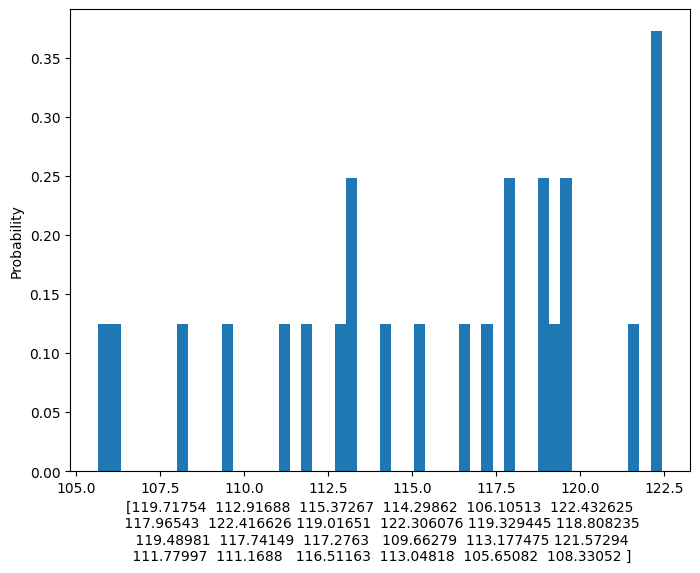

In [27]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))

plt.hist(y_pred, density=True, bins=50)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel(y_pred)
plt.show()

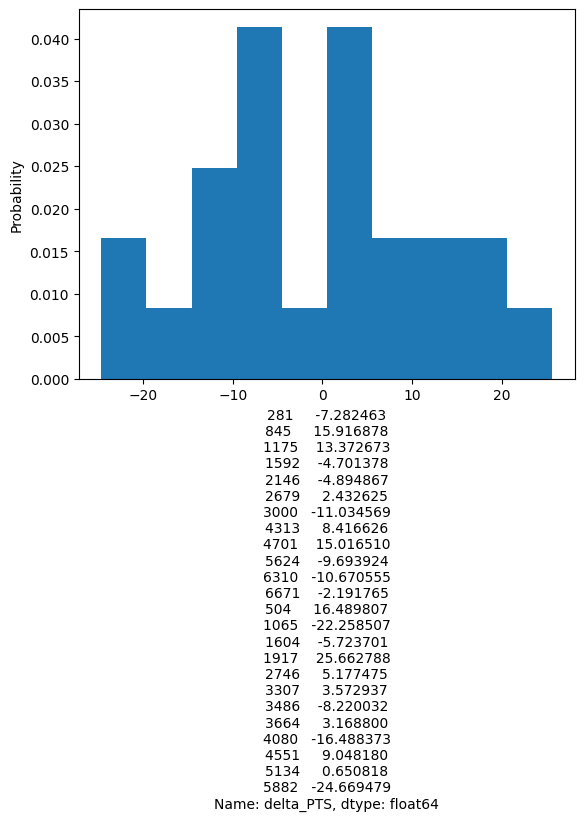

In [28]:

# Look at the distribution of errors
error_dist_df = pd.DataFrame()
error_dist_df['delta_PTS'] = y_pred -y_test
plt.hist(error_dist_df['delta_PTS'], density=True, bins=10)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel(error_dist_df['delta_PTS'])
plt.show()

In [29]:
# Do a t-test to confirm whether today's predictions match distribution of validation datasets

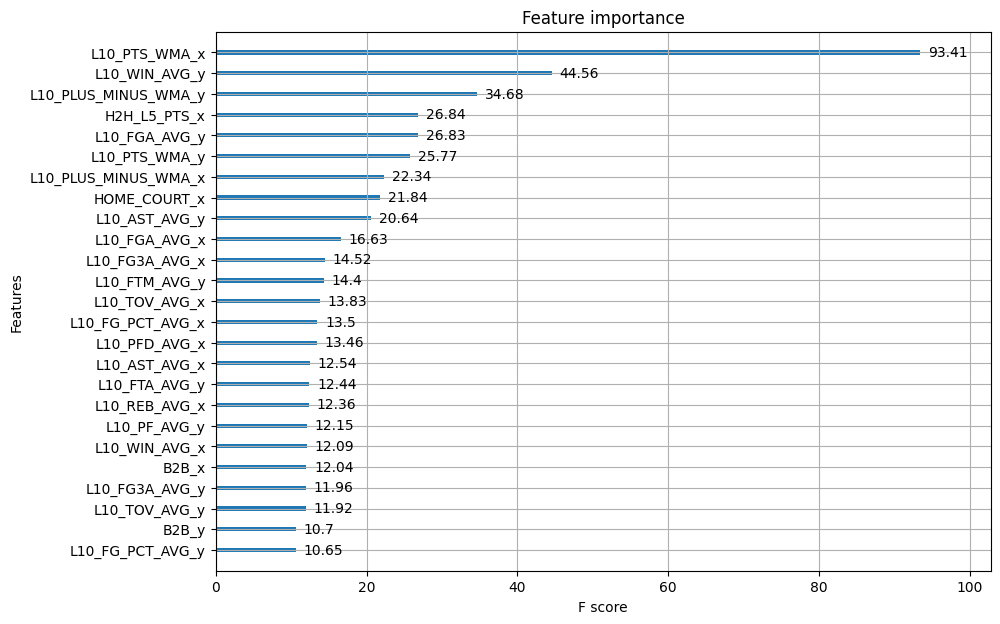

In [30]:
from matplotlib import pyplot as plt

# Get the booster from the xgbmodel
booster = model.get_booster()

# Get the importance dictionary (by gain) from the booster
importance = booster.get_score(importance_type="gain")

# make your changes
for key in importance.keys():
    importance[key] = round(importance[key],2)

# provide the importance dictionary to the plotting function
ax = xgb.plot_importance(importance, max_num_features=25, importance_type='gain', show_values=True)
fig = ax.figure
fig.set_size_inches(10, 7)

In [31]:
# X_test = pd.DataFrame(X_test)

In [32]:
X_test['y_pred_PTS'] = y_pred
X_test['y_test_PTS'] = y_test

In [33]:
# Look at a histogram of delta between y_hat and PTS_x

In [34]:
yest_str = (datetime.now() - timedelta(days=1)).strftime('%Y-%m-%d')

# Evaluating Results
yesterday_results_df = pre_model_df[pre_model_df['GAME_DATE']==yesterday]
yesterday_results_df = pd.concat([yesterday_results_df, X_test[['y_pred_PTS']]], axis=1)

# Save to Tracking File
# yesterday_results_df[['TEAM_ABBREVIATION_x','y_pred_PTS','PTS_x']].to_csv(f'/home/NBA_Team_Total/results_{yest_str}.csv')

yesterday_results_df = yesterday_results_df[['GAME_DATE','TEAM_NAME_x','TEAM_NAME_y','y_pred_PTS', 'PTS_x']]
yesterday_results_df['delta_PTS'] =  yesterday_results_df['PTS_x'] - yesterday_results_df['y_pred_PTS']

yesterday_results_df.sort_values('TEAM_NAME_x', inplace=True)

yesterday_results_df.to_csv(f'/home/results_{yest_str}.csv')
yesterday_results_df.head(20)

,GAME_DATE,TEAM_NAME_x,TEAM_NAME_y,y_pred_PTS,PTS_x,delta_PTS
5624,2025-03-10T00:00:00,Atlanta Hawks,Philadelphia 76ers,122.306076,132,9.693924
4313,2025-03-10T00:00:00,Boston Celtics,Utah Jazz,122.416626,114,-8.416626
2146,2025-03-10T00:00:00,Brooklyn Nets,Los Angeles Lakers,106.105133,111,4.894867
5134,2025-03-10T00:00:00,Charlotte Hornets,Miami Heat,105.650818,105,-0.650818
6671,2025-03-10T00:00:00,Chicago Bulls,Indiana Pacers,118.808235,121,2.191765
4080,2025-03-10T00:00:00,Dallas Mavericks,San Antonio Spurs,116.511627,133,16.488373
1065,2025-03-10T00:00:00,Denver Nuggets,Oklahoma City Thunder,117.741493,140,22.258507
6310,2025-03-10T00:00:00,Golden State Warriors,Portland Trail Blazers,119.329445,130,10.670555
845,2025-03-10T00:00:00,Houston Rockets,Orlando Magic,112.916878,97,-15.916878
504,2025-03-10T00:00:00,Indiana Pacers,Chicago Bulls,119.489807,103,-16.489807


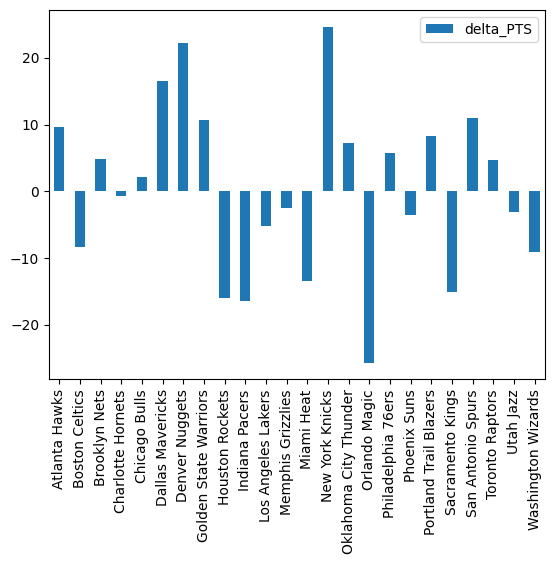

In [35]:
team_list = yesterday_results_df['TEAM_NAME_x'].unique().tolist()

plot_df = yesterday_results_df.reset_index(names=team_list)
plot_df[['TEAM_NAME_x','delta_PTS']].plot.bar()
plt.xticks(np.arange(len(team_list)), team_list)
plt.show()

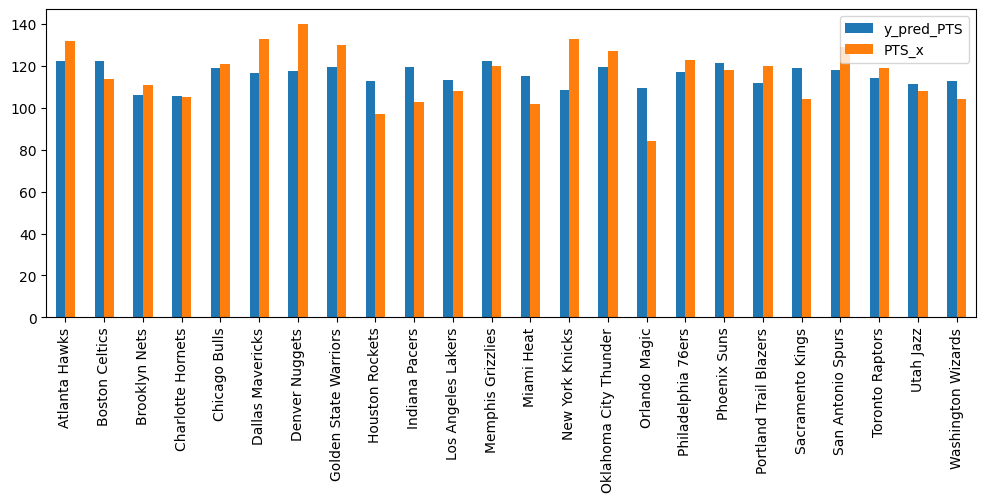

In [36]:
plt.rcParams['figure.figsize'] = [12, 4]
plot_df[['y_pred_PTS','PTS_x']].plot.bar()
plt.xticks(np.arange(len(team_list)), team_list)
plt.show()

In [37]:
today = datetime.now().strftime('%Y-%m-%d')

def dfAnalysisPrep(df):
  prepped_df = df.drop(['TEAM_ID_x','TEAM_ID_y','TEAM_ABBREVIATION_x','TEAM_ABBREVIATION_y','TEAM_NAME_x','TEAM_NAME_y','GAME_DATE',
                        'WL_BOOL_x', 'MATCHUP_TEAM_ABBREVIATION_x', 'MATCHUP_TEAM_ABBREVIATION_y', 'LAST_GAME_DATE_x', 'LAST_GAME_DATE_y',
                        'SCHED_TEAM_NAME_x', 'SCHED_TEAM_NAME_y','FUTURE_MATCHUP_TEAM_NAME_x',
                        'FUTURE_MATCHUP_TEAM_NAME_y', 'WL_BOOL_y'], axis=1, inplace=False)
  return prepped_df

corr_df = dfAnalysisPrep(pre_model_df).corr()
corr_df['ABS_PTS_x'] = np.abs(corr_df['PTS_x'])
corr_df =corr_df[['PTS_x', 'ABS_PTS_x']]

corr_df = corr_df[corr_df.index != 'PTS_x']
corr_df = corr_df[corr_df.index != 'WL_BOOL_y']
corr_df = corr_df[corr_df.index != 'PTS_y']
corr_df = corr_df.sort_values('ABS_PTS_x', ascending=False)

corr_df.to_csv(f'/home/feature_corr_{today}.csv')

<Axes: >

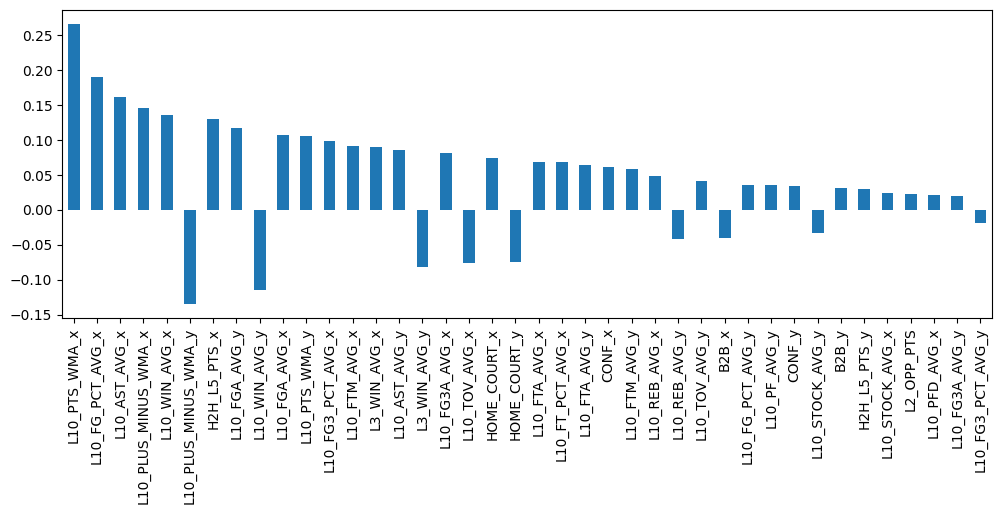

In [38]:
corr_df['PTS_x'].head(40).plot.bar()

# Predictions for Today

In [39]:
# PREDICTIONS FOR TODAY
today_fmt = datetime.now()# + timedelta(days=1)
today_fmt = today_fmt.strftime('%Y-%m-%dT00:00:00')

tomorrow_fmt = datetime.now() + timedelta(days=1)
tomorrow_fmt = tomorrow_fmt.strftime('%Y-%m-%dT00:00:00')

# prelim_features_list.append('GAME_DATE')

# model_test_today_df = pre_model_test_df[pre_model_test_df['GAME_DATE']==today_fmt].sort_values('TEAM_NAME_x', inplace=True)

pred_df = pre_model_test_df.drop(['key_0_x', 'TEAM_ABBREVIATION_x_x', 'SCHED_TEAM_NAME_x_x', 'date_x', 'SCHED_TEAM_NAME_y_x', 'TEAM_ABBREVIATION_y_x',
                                  'key_0_y', 'TEAM_ABBREVIATION_x_y', 'SCHED_TEAM_NAME_x_y', 'date_y', 'SCHED_TEAM_NAME_y_y', 'TEAM_ABBREVIATION_y_y'], axis=1, inplace=False)

X_train = dfPrep(pred_df[pred_df['GAME_DATE']!=today_fmt])
y_train = pred_df[pred_df['GAME_DATE']!=today_fmt]['PTS_x']
# X_test = dfPrep(pred_df[pred_df['GAME_DATE']==today_fmt])
y_res = dfPrep(pred_df[pred_df['GAME_DATE']==today_fmt])

# Create an XGBoost regressor
model = xgb.XGBRegressor(booster='gbtree',
                        objective='reg:absoluteerror',
                         eval_metric='rmse',
                         learning_rate=0.12,
                         max_depth=2,
                         min_child_weight=2,
                         max_delta_step=0,
                         gamma=0.1,
                         subsample=1,
                         reg_lambda=1,
                         tree_method='hist',
                         max_leaves=4,
                         colsample_bytree=0.99) #reg:squarederror

# Train the model and make predictions
model.fit(X_train, y_train)
y_pred = model.predict(y_res)
y_res['y_pred_PTS'] = y_pred


# Evaluating Results
pred_results_df = pred_df[pred_df['GAME_DATE']==today_fmt]
pred_results_df = pd.concat([pred_results_df,  y_res[['y_pred_PTS']]], axis=1)

####
pred_results_df['SCHED_TEAM_NAME_x'] = pred_results_df['TEAM_NAME_x'].str.rsplit(' ', n=1).str[0]
pred_results_df.loc[pred_results_df['TEAM_NAME_x']=='LA Clippers', 'SCHED_TEAM_NAME'] = 'LA'
pred_results_df.loc[pred_results_df['TEAM_NAME_x']=='Portland Trail Blazers', 'SCHED_TEAM_NAME_x'] = 'Portland'

pred_results_df['SCHED_TEAM_NAME_y'] = pred_results_df['TEAM_NAME_y'].str.rsplit(' ', n=1).str[0]
pred_results_df.loc[pred_results_df['TEAM_NAME_y']=='LA Clippers', 'SCHED_TEAM_NAME'] = 'LA'
pred_results_df.loc[pred_results_df['TEAM_NAME_y']=='Portland Trail Blazers', 'SCHED_TEAM_NAME_y'] = 'Portland'
####

pred_results_df = pred_results_df[['GAME_DATE','SCHED_TEAM_NAME_x','SCHED_TEAM_NAME_y','y_pred_PTS']]

pred_results_df.sort_values('SCHED_TEAM_NAME_x', inplace=True)

# Save to Tracking File
pred_results_df.to_csv(f'/home/predictions_{today_fmt}.csv')

# Get ESPN Odds Data for Comparison
espn_odds_df = team_lookup_df.merge(nba_todays_schedule_df,
                                          how = 'inner',
                                          left_on=team_lookup_df.SCHED_TEAM_NAME,
                                          right_on=nba_todays_schedule_df.TEAM1)

try:
  espn_odds_df.drop('key_0', axis=1, inplace=True)
except KeyError:
  pass

espn_odds_df = espn_odds_df.merge(team_lookup_df,
                                          how = 'inner',
                                          left_on=espn_odds_df.TEAM2,
                                          right_on=team_lookup_df.SCHED_TEAM_NAME)[['SCHED_TEAM_NAME_x','TEAM_ABBREVIATION_x','SCHED_TEAM_NAME_y','TEAM_ABBREVIATION_y',
                                                                                  'ESPN_SPREAD_AMT','ESPN_SPREAD_FAV','ESPN_IMPLD_DOG_TOTAL',
                                                                                  'ESPN_GAME_TOTAL','ESPN_IMPLD_FAV_TOTAL']]

In [40]:
espn_odds_df['TEAM_NAME_x_IMP_SCORE'] = np.where(espn_odds_df['TEAM_ABBREVIATION_x']==espn_odds_df['ESPN_SPREAD_FAV'], espn_odds_df['ESPN_IMPLD_FAV_TOTAL'],
                                        np.where(espn_odds_df['TEAM_ABBREVIATION_x']!=espn_odds_df['ESPN_SPREAD_FAV'], espn_odds_df['ESPN_IMPLD_DOG_TOTAL'], None))

espn_odds_df['TEAM_NAME_y_IMP_SCORE'] = np.where(espn_odds_df['TEAM_ABBREVIATION_y']==espn_odds_df['ESPN_SPREAD_FAV'], espn_odds_df['ESPN_IMPLD_FAV_TOTAL'],
                                        np.where(espn_odds_df['TEAM_ABBREVIATION_y']!=espn_odds_df['ESPN_SPREAD_FAV'], espn_odds_df['ESPN_IMPLD_DOG_TOTAL'], None))

try:
  espn_odds_df.drop('key_0', axis=1, inplace=True)
except KeyError:
  pass

# espn_odds_df.head()
pred_matchup_res_df = pred_results_df.merge(espn_odds_df,
                                            how='inner',
                                            left_on=pred_results_df.SCHED_TEAM_NAME_x,
                                            right_on=espn_odds_df.SCHED_TEAM_NAME_x)[['GAME_DATE', 'SCHED_TEAM_NAME_x_x', 'SCHED_TEAM_NAME_y_x', 'y_pred_PTS',
                                                                                      'TEAM_NAME_x_IMP_SCORE', 'TEAM_NAME_y_IMP_SCORE', 'ESPN_GAME_TOTAL', 'ESPN_SPREAD_AMT']]

pred_matchup_res_df.rename(columns={'SCHED_TEAM_NAME_x_x': 'TEAM_NAME_x', 'SCHED_TEAM_NAME_y_x': 'TEAM_NAME_y'}, inplace=True)


pred_matchup_res_df = pred_matchup_res_df.merge(pred_results_df,
                                                how='inner',
                                                left_on=pred_matchup_res_df.TEAM_NAME_y,
                                                right_on=pred_results_df.SCHED_TEAM_NAME_x)[['GAME_DATE_x', 'TEAM_NAME_x', 'TEAM_NAME_y', 'y_pred_PTS_x','y_pred_PTS_y',
                                                                                             'TEAM_NAME_x_IMP_SCORE', 'TEAM_NAME_y_IMP_SCORE', 'ESPN_GAME_TOTAL', 'ESPN_SPREAD_AMT']]

pred_matchup_res_df.rename(columns={'GAME_DATE_x': 'GAME_DATE', 'y_pred_PTS_x': 'TEAM_x_pred_PTS', 'y_pred_PTS_y': 'TEAM_y_pred_PTS'}, inplace=True)

pred_matchup_res_df['ESPN_SPREAD_AMT'] = np.where(pred_matchup_res_df['TEAM_NAME_x_IMP_SCORE']>pred_matchup_res_df['TEAM_NAME_y_IMP_SCORE'], (pred_matchup_res_df['ESPN_SPREAD_AMT']*-1),
                                         np.where(pred_matchup_res_df['TEAM_NAME_x_IMP_SCORE']<pred_matchup_res_df['TEAM_NAME_y_IMP_SCORE'], pred_matchup_res_df['ESPN_SPREAD_AMT'], 0.0))

pred_matchup_res_df['pred_GAME_SPREAD'] = (pred_matchup_res_df['TEAM_x_pred_PTS'] - pred_matchup_res_df['TEAM_y_pred_PTS']).round(1)

pred_matchup_res_df['pred_GAME_TOTAL'] = pred_matchup_res_df['TEAM_x_pred_PTS'] + pred_matchup_res_df['TEAM_y_pred_PTS']

pred_matchup_res_df = pred_matchup_res_df[['GAME_DATE','TEAM_NAME_x','TEAM_NAME_y','TEAM_x_pred_PTS','TEAM_y_pred_PTS','pred_GAME_SPREAD','pred_GAME_TOTAL','TEAM_NAME_x_IMP_SCORE','TEAM_NAME_y_IMP_SCORE','ESPN_GAME_TOTAL','ESPN_SPREAD_AMT']]

pred_matchup_res_df.to_csv(f'/home/consolidated_predictions_{today_fmt}.csv')

pred_matchup_res_df.head(16)

,GAME_DATE,TEAM_NAME_x,TEAM_NAME_y,TEAM_x_pred_PTS,TEAM_y_pred_PTS,pred_GAME_SPREAD,pred_GAME_TOTAL,TEAM_NAME_x_IMP_SCORE,TEAM_NAME_y_IMP_SCORE,ESPN_GAME_TOTAL,ESPN_SPREAD_AMT
0,2025-03-11T00:00:00,Brooklyn,Cleveland,109.423401,117.634140,-8.2,227.057541,105.0,123.0,228.5,-18.0
1,2025-03-11T00:00:00,LA,New Orleans,117.666664,114.941917,2.7,232.608582,115.0,108.0,223.5,6.5
2,2025-03-11T00:00:00,Milwaukee,Indiana,114.914246,114.254135,0.7,229.168381,119.0,115.0,234.5,3.5
3,2025-03-11T00:00:00,Washington,Detroit,110.694328,115.196213,-4.5,225.890533,109.5,123.5,233.5,-14.0


In [41]:
# import smtplib
# from os.path import basename
# from email.mime.application import MIMEApplication
# from email.mime.multipart import MIMEMultipart
# from email.mime.text import MIMEText
# from email.utils import COMMASPACE, formatdate


# def send_mail(send_from, send_to, subject, text, files=None,
#               server="127.0.0.1"):
#     assert isinstance(send_to, list)

#     msg = MIMEMultipart()
#     msg['From'] = send_from
#     msg['To'] = COMMASPACE.join(send_to)
#     msg['Date'] = formatdate(localtime=True)
#     msg['Subject'] = subject

#     msg.attach(MIMEText(text))

#     for f in files or []:
#         with open(f, "rb") as fil:
#             part = MIMEApplication(
#                 fil.read(),
#                 Name=basename(f)
#             )
#         # After the file is closed
#         part['Content-Disposition'] = 'attachment; filename="%s"' % basename(f)
#         msg.attach(part)


#     smtp = smtplib.SMTP(server)
#     smtp.sendmail(send_from, send_to, msg.as_string())
#     smtp.close()

In [42]:
# send_mail(send_from = 'noreply@fdsfdsfadsafdsafdsafds.com',
#           send_to = ['mycotropic1@gmail.com'], # Changed to a list
#           subject = "Projections for tomorrow",
#           text = "See Attached.",
#           # server="127.0.0.1",
#           files=[f'/home/predictions_{today_fmt}.csv'])

In [43]:
# from google.colab import sheets
# sheet = sheets.InteractiveSheet(df=pred_matchup_res_df)

In [44]:
# Histogram of teams previous scores with a vertical line showing today's prediction

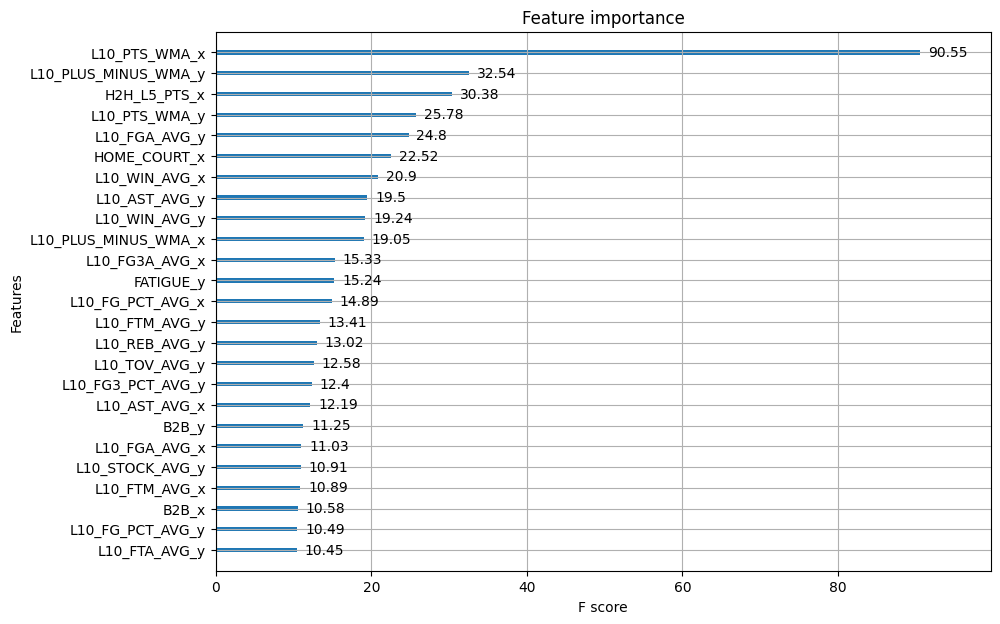

In [45]:
from matplotlib import pyplot as plt

# Get the booster from the xgbmodel
booster = model.get_booster()

# Get the importance dictionary (by gain) from the booster
importance = booster.get_score(importance_type="gain")

# make your changes
for key in importance.keys():
    importance[key] = round(importance[key],2)

# provide the importance dictionary to the plotting function
ax = xgb.plot_importance(importance, max_num_features=25, importance_type='gain', show_values=True)
fig = ax.figure
fig.set_size_inches(10, 7)

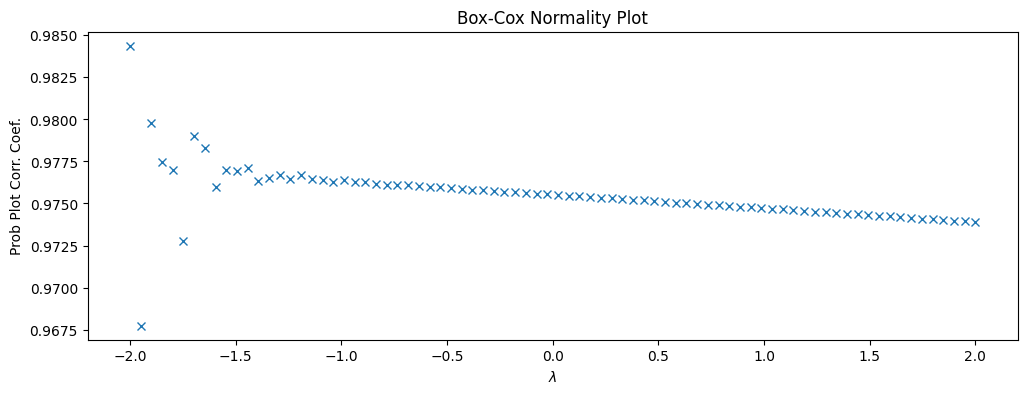

In [46]:
from scipy import stats

# Generate some non-normal data
# data = np.random.exponential(scale=2, size=100)
data = pred_matchup_res_df['pred_GAME_TOTAL']

# Create the Box-Cox normality plot
fig = plt.figure()
ax = fig.add_subplot(111)
stats.boxcox_normplot(data, -2, 2, plot=ax)
plt.show()

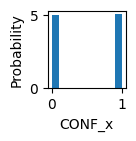

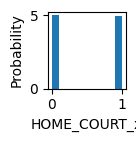

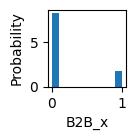

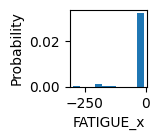

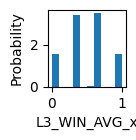

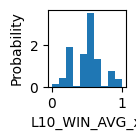

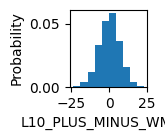

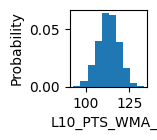

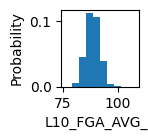

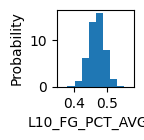

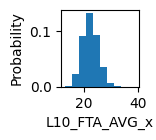

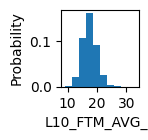

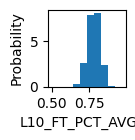

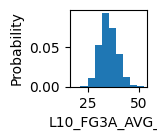

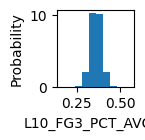

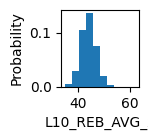

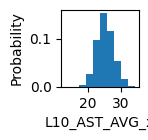

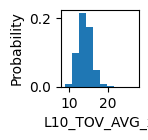

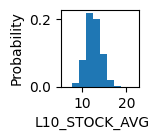

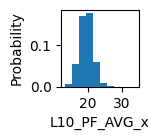

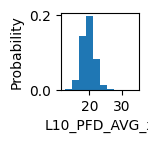

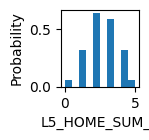

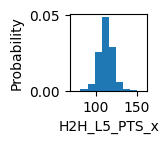

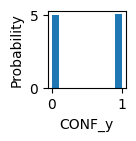

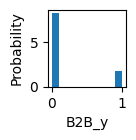

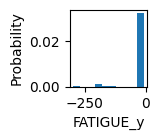

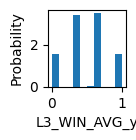

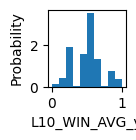

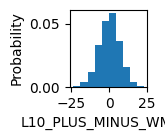

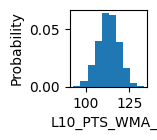

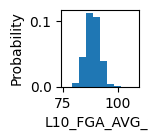

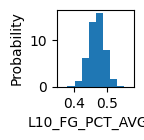

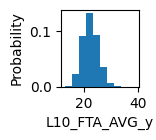

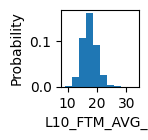

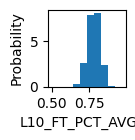

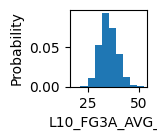

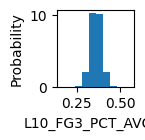

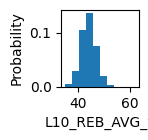

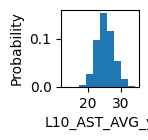

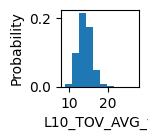

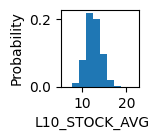

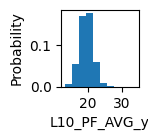

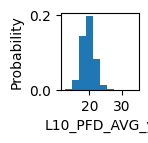

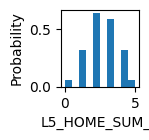

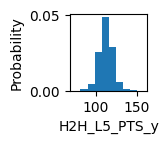

In [47]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.rcParams['figure.figsize'] = [1, 1]

for col_name in X_train.columns:
  plt.hist(X_train[col_name], density=True, bins=10)  # density=False would make counts
  plt.ylabel('Probability')
  plt.xlabel(col_name)
  plt.show()


In [48]:
# knicks_scores_df = df_season[(df_season['TEAM_ABBREVIATION']=='NYK') & (df_season['PTS'].notnull()) & (df_season['SEASON_YEAR']=='2024-25')]

# import matplotlib.pyplot as plt
# import numpy as np
# %matplotlib inline

# plt.rcParams['figure.figsize'] = [5, 5]

# for col_name in knicks_scores_df.columns:
#   plt.hist(knicks_scores_df[col_name], density=True, bins=10)  # density=False would make counts
#   plt.ylabel('Probability')
#   plt.xlabel(col_name)
#   plt.show()